In [1]:
import nibabel as nib
import numpy as np
import os
import glob
import sys
import SimpleITK as sitk
# !{sys.executable} -m pip install seaborn
# !{sys.executable} -m pip install pandas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ipynb.fs.full.io_utils import search_file_in_folder_list

In [2]:
def compute_dice(seg1, seg2, label=1.0):
    # flatten the segmentations
    seg1 = seg1.flatten()
    seg2 = seg2.flatten()

    if len(seg1) != len(seg2):
        raise InputError('The two segmentations have different dimensions - not comparable!')

    yt = np.asarray(seg1 == label, np.float32)
    yp = np.asarray(seg2 == label, np.float32)
    
    intersection = np.multiply(yt, yp)
    union = np.asarray(yt + yp > 0, np.float32)
    dice = 2 * np.sum(intersection) / (np.sum(yt) + np.sum(yp) + 1e-10)
    
    return dice

In [3]:
def load_nifty_volume_as_4d_array(filename):
    img_obj = sitk.ReadImage(filename)
    data_array = sitk.GetArrayFromImage(img_obj)
    spacing = img_obj.GetSpacing()
    direction = img_obj.GetDirection()
    shape = data_array.shape
    if(len(shape) == 4):
        data_array = np.moveaxis(data_array, 0, -1) 
    elif(len(shape) == 3):
        data_array = np.expand_dims(data_array, axis = -1)
    else:
        raise ValueError("unsupported image dim: {0:}".format(len(shape)))
    output = {}
    output['data_array'] = data_array
    output['spacing']    = (spacing[2], spacing[1], spacing[0])
    output['direction']  = direction
    return output

In [4]:
def read_nifti(nifti_file):
#     img_nii = nib.load(nifti_file)
#     img = img_nii.get_fdata()
    
    img_dict = load_nifty_volume_as_4d_array(nifti_file)
    img = img_dict['data_array']
    
    # if two channels, get the foreground one
    if img.shape[3] > 1:
        img = img[..., 1]
        
    return img

In [5]:
# set parameters:
# net_out_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_3D_unet/" +
#                 "2020-08-05_17-47-42_CustomUNet25_inplane_Resize_outplaneCrop_larger_filters/inf_on_training_valid_key_metric=0.8792"]
net_out_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_3D_unet/" +
                "2020-08-05_17-47-42_CustomUNet25_inplane_Resize_outplaneCrop_larger_filters/inf_on_validation_valid_key_metric=0.8792"]
is_validation_set = True

# list folders to search for the data
data_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset/GroupA", 
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset/GroupB1",
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset/GroupB2", 
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset_extension/GroupC",
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset_extension/GroupD",
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset_extension/GroupE",
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset_extension/GroupF"]

# list of subject IDs to search for data
list_root = "/mnt/data/mranzini/Desktop/GIFT-Surg/Retraining_with_expanded_dataset/config/file_names"
if not is_validation_set:
    training_list = [os.path.join(list_root, "list_train_files.txt")]
else:
    training_list = [os.path.join(list_root, "list_validation_h_files.txt"),
                    os.path.join(list_root, "list_validation_p_files.txt")]

full_list = {"subj_id": [], "Dice": [], "Group": []}
for scan_list in training_list:
    with open(scan_list) as f:
        for line in f:
            subject = line.rstrip()
            print(subject)
            image_basename = "{}{}.nii.gz".format(subject, '_Image')
            image_filename = search_file_in_folder_list(data_root, image_basename)
            label_basename = "{}{}.nii.gz".format(subject, '_Label')
            label_filename = search_file_in_folder_list(data_root, label_basename)
            output_basename = os.path.join("{}_Image".format(subject), "{}_Image_seg.nii.gz".format(subject))
            output_filename = search_file_in_folder_list(net_out_root, output_basename)
            get_group = image_filename[image_filename.find("Group") + 5]
            if get_group == "B":
                get_group = image_filename[image_filename.find("Group") + 5] + \
                    image_filename[image_filename.find("Group") + 6]
                
            if os.path.isfile(image_filename) and os.path.isfile(label_filename) and os.path.isfile(output_filename):
                # compute Dice between gt and seg
                label = np.squeeze(read_nifti(label_filename))
                output = np.squeeze(read_nifti(output_filename))
                output_bin = output > 0.5
                full_list['subj_id'].append(subject)
                full_list['Dice'].append(compute_dice(label, output_bin))
                full_list['Group'].append(get_group)
            else:
                raise IOError('Expected files not found for subject {}'.format(subject))


a04_02
a04_03
a04_05
a15_04
a15_08
a15_10
a23_02
a23_03
a23_04
b80_05
b80_06
b80_08
17_03_08
17_03_18
17_03_19
17_09_08
17_09_20
17_09_21
17_23_04
17_23_05
17_23_06
17_31_05
17_31_06
17_31_07
C02_01
C02_02
C02_03
C02_04
C02_05
C02_06
C02_07
C02_08
C11_01
C11_02
C11_03
C11_04
C11_05
D03_01
D03_02
D03_03
D03_04
D03_05
E11_01
E11_02
E11_03
E11_04
E11_05
E11_06
E11_07
E11_08


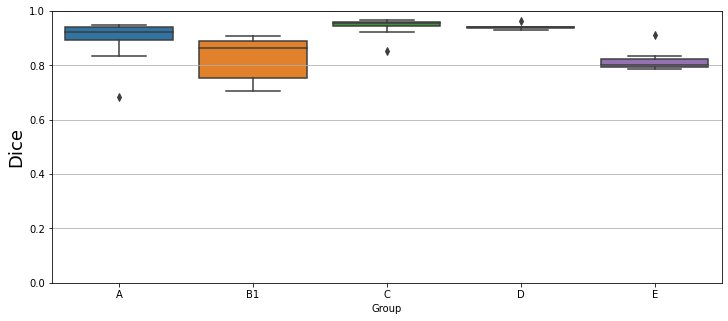

In [6]:
pd1 = pd.DataFrame(data=full_list)

fig = plt.figure(figsize=(12, 5))
b1 = sns.boxplot(x='Group', y='Dice', data=pd1)
b1.set_ylabel('Dice', fontsize=18)
b1.set_ylim([0, 1])
plt.grid(b=True,axis='y')

In [8]:
full_list["Dice"] = np.asarray(full_list["Dice"])
idx = np.squeeze(np.argwhere(full_list["Dice"] < 0.75), axis=-1)
print([full_list['subj_id'][i] for i in idx])
print([full_list['Dice'][i] for i in idx])

['a23_02', '17_03_18', '17_03_19', '17_09_21']
[0.6851022148052742, 0.7057774862016339, 0.7303334250481485, 0.7317073170731669]
